# **Starting with Pytorch**

PyTorch is an open-source deep learning framework developed by Facebook's AI Research lab. It provides a flexible and dynamic approach to building neural networks, making it a favorite among researchers and developers alike. PyTorch's clear and straightforward API makes it accessible for beginners, while its depth and versatility cater to advanced use cases in cutting-edge AI research.

## Importing Libraries and Modules

Google Colab already has everything you need installed. We highly recommend to use Colab for these tutorials, however, if you want to use your own environment, you will need to set up a Python ecosystem and install Pytorch on it.

You can find support for your own platforms and versiosn from the [Pytorch website](https://pytorch.org/get-started/locally/).

Let's start with an easy example. First of all, we will import NumPy and define the seed for the pseudorandom number generator. Specifying the seed is a common practice because different initializations might lead to varying results.

In [ ]:
import numpy as np
np.random.seed(1234)  # for reproducibility

Now we are ready to import some of the Pytorch's modules.

First, we will import the Sequential module from Pytorch. A Sequential module is a stack of neural network layers. We will need it for creating our first feed-forward neural network.

In [ ]:
from torch.nn import Sequential

PyTorch's framework provides dynamic computation graphs and native support for GPU acceleration. In this tutorial, we will use PyTorch for building and training our neural networks. Similar to NumPy, we fix PyTorch’s pseudorandom number generators to ensure reproducibility.

In [ ]:
import torch
torch.manual_seed(123)

Next we look at two of the core layers used to build a network on Pytorch: [Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) and Activations such as [ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [Softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax). In short, the `Linear` defines a fully-connected network where all the neurons are connected to all of the elements of the input data, and the `Activations` define a non-linear function applied to the network. We will explain more about those layers in the following tutorials.

In [ ]:
from torch.nn import Linear, ReLU

Both of these are part of the [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) package, from which they can be imported. Thus, often, it is more practical to import the whole `nn` module.

In [ ]:
import torch.nn as nn

We will also need the optimiser package in order to train our network, alongside some functions from the utilities package to aid the preprocesisng of our data.

In [ ]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In addition, we need to import some utils, that will help us later with the visualisation and transformation of the dataset.

In [ ]:
!pip install torchinfo

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchinfo import summary

## Loading Datasets from Pytorch

Besides the modules to build our neural networks, Pytorch library also contains a set of [standard datasets](https://docs.pytorch.org/vision/stable/datasets.html). The fact that those datasets are inside Pytorch is handy and can save us a lot of time when learning how to create our first neural network.

Therefore, let's import the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. MNIST is a popular dataset on the computer vision community that contains a large number of binary images of handwritten digits. Once loaded, Pytorch allows us to easily split the dataset into the commonly used train and test data splits.

In [ ]:
from torchvision import datasets, transforms

# Load MNIST dataset
transform = transforms.ToTensor()  # keeps shape and scales to [0,1]
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert to numpy arrays for inspection and visualization
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.35MB/s]


We can now look into the shape of the imported data and visualise some examples:

Image shape: (28, 28)
Total number of training samples: 60000
Total number of test samples: 10000


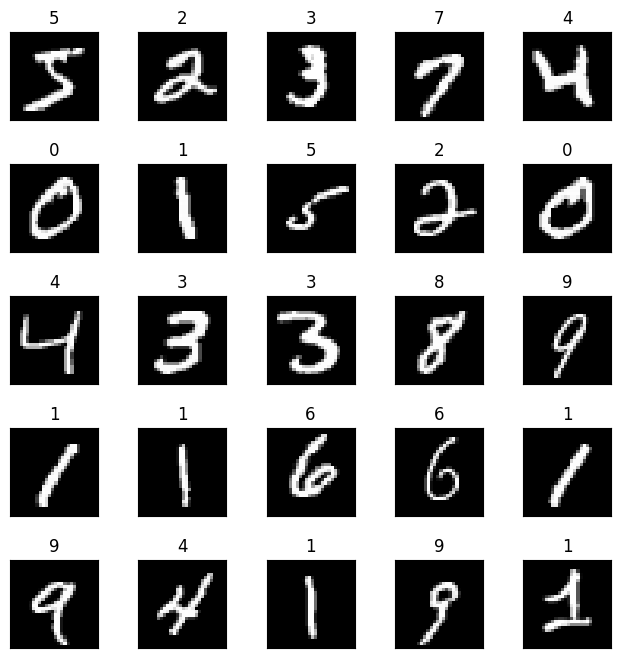

In [ ]:
# Print dataset info
print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of test samples: {0}'.format(X_test.shape[0]))

# Visualization: show N x N grid of images
N = 5
start_val = 0  # starting index
fig, axes = plt.subplots(N, N, figsize=(8, 8))
items = list(range(0, 10))

for row in range(N):
    for col in range(N):
        idx = start_val + row + N * col
        axes[row, col].imshow(X_train[idx], cmap='gray')
        fig.subplots_adjust(hspace=0.5)
        y_target = int(y_train[idx])
        target = str(items[y_target])
        axes[row, col].set_title(target)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.show()

We have 60000 training samples and 10000 test samples, where each image has a shape of 28×28 pixels. Visualising the data before deploying any algorithm is always a good idea: it is a quick sanity check that can prevent avoidable mistakes.

## Preprocessing Pytorch Datasets

In this first example, we train a simple model to classify the digits on MNIST dataset.

As will be studied in the lectures, convolutional layers are usually employed to classify images. However, for the time being, we use only `Linear` layers. Thus, we have to reshape the images into a 1D array to have a single dimension, and define an architecture that could be used in any 1D data, *e.g.*, time series. We will see on following weeks that when using Convolutional Neural Networks (CNNs) we must define a 3D shape for images (depth, width, height). CNNs usually have higher performance compared to models with only `Linear` layers when applied to 2D data.

Let's transform the 2D images into 1D arrays.

In [ ]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

print('New X_train shape: {0}'.format(X_train_flatten.shape))

New X_train shape: (60000, 784)


A standard practise is to normalise the dataset to the range $[0, 1]$.

In [ ]:
X_train_flatten = X_train_flatten.astype('float32')
X_test_flatten = X_test_flatten.astype('float32')
X_train_flatten /= 255
X_test_flatten /= 255

We train a classifier in a supervised manner, and therefore, we need to process the labels so that our pipeline can use them. The `y_train` and `y_test` labels indicate the numerical values belonging to the `X_train` and `X_test` images.

We use a Categorical CrossEntropy as the loss function, which accepts class label indices in Pytorch.

In [ ]:
# Assuming y_train and y_test are NumPy arrays
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

After this, we group the training data inputs and labels using the `DataLoader` function to feed it to our network.

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_flatten).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test_flatten).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Architecture


Defining a model architecture is a critical step when trying to solve a machine learning problem. In this tutorial, we will understand how models can be built into Pytorch.

First, we need to declare a `Sequential` module. As mentioned, the `Sequential` module allows us to combine neural network layers linearly. We create a model by passing a list of layer instances to the `Sequential` module:

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)

- `dim=1` means you're applying softmax across the class scores for each sample in a batch (i.e., across columns).

- If you're using nn.CrossEntropyLoss, do not include nn.Softmax — it's already built into the loss.

We now have a simple model ready to go!

Note that the model needs to know the shape of the input data. For this reason, the first layer in the Sequential model needs information about the input shape (the following layers can automatically infer the shape, and you do not need to specify it). In our case, we tell the network that the input size is 784. The 784 size vector comes from the flatten operation of our images (28 x 28). If we were using directly images, the input shape would have been (1, 28, 28), which corresponds to the (depth, width, height) of each digit image. The formatting (depth, width, height) is called `channels_first`, which is used by default in Pytorch. This is the opposite of Keras, which uses `channels_last` by default (height, width, channels), but PyTorch does not provide a data_format option — you'll need to manually transpose if converting between formats.

Let's print the model shape output by passing in a dummy input and viewing the shape of the output:

In [ ]:
# Create dummy input with the same shape as your training data
# For flattened MNIST (28x28), input shape is [batch_size, 784]
dummy_input = torch.randn(1, 784)  # batch size of 1

# Pass it through the model
output = model(dummy_input)

# Print the shape of the output
print("Output shape:", output.shape)


Output shape: torch.Size([1, 10])


We define the output of our layer to be 10, that corresponds to the 10 different classes in MNIST (one, two, three, ..., nine.). Pytorch automatically handles the connections between layers, so there is no need for us to manually set up anything within the architecture.

To get a summary of the model architecture (similar to Keras' .summary()), you can use the torchinfo package:

In [ ]:
summary(model, input_size=(1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Linear: 1-1                            [1, 10]                   7,850
├─Softmax: 1-2                           [1, 10]                   --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In our example, the first row of the table has $784\cdot 10+ 10=7850$ parameters, where the first term refers to the connections between input data and neurons,  and the second term to the output bias.

## Training setup

Before training our model, we need to configure the learning process. We must define three important parameters here:

*   The loss function that the model will try to minimise.
*   The optimiser used to minimise the loss function and update the weights of the network.
*   The list of metrics you want the model to compute in every step.

In our example, as we are doing classification, we will define the `categorical_crossentropy` as the loss function, and we will compute the accuracy metric. You can refer to Pytorch documentation to learn more about [losses](https://docs.pytorch.org/docs/stable/nn.html#loss-functions) or [optimisers](https://docs.pytorch.org/docs/stable/optim.html/). Many other parameters could be tuned, e.g., learning rate, decay factor, or weight normalisation. We will explore in more detail all of these parameters in the following tutorials. For now, we will use the default values for them.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Metrics: PyTorch does not provide built-in metrics like Keras.
# You compute metrics manually during training or validation, e.g., accuracy:
def accuracy(output, target):
    preds = output.argmax(dim=1)
    correct = (preds == target).sum().item()
    return correct / target.size(0)

## Training

To train the model, we must define our training loop. We have to define the number of total epochs the model is going to train. Within the loop, we set the model into training mode, perform a forward pass, compute the loss, perform a backwards pass and log any metrics we desire. We are finally ready to start the learning of our classifier!

In [ ]:
# Training loop
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()                             # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()                 # Clear gradients
        outputs = model(inputs)               # Forward pass
        loss = criterion(outputs, labels)     # Compute loss
        loss.backward()                       # Backward pass
        optimizer.step()                      # Update weights

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Accuracy: {accuracy:.4f}")

    train_losses.append(running_loss)
    train_accuracies.append(accuracy)


Epoch [1/10] - Loss: 3096.0478 - Accuracy: 0.8677
Epoch [2/10] - Loss: 2942.8925 - Accuracy: 0.9118
Epoch [3/10] - Loss: 2918.9252 - Accuracy: 0.9192
Epoch [4/10] - Loss: 2906.4053 - Accuracy: 0.9235
Epoch [5/10] - Loss: 2898.1083 - Accuracy: 0.9265
Epoch [6/10] - Loss: 2892.3729 - Accuracy: 0.9287
Epoch [7/10] - Loss: 2887.6722 - Accuracy: 0.9304
Epoch [8/10] - Loss: 2883.8690 - Accuracy: 0.9321
Epoch [9/10] - Loss: 2880.9243 - Accuracy: 0.9330
Epoch [10/10] - Loss: 2878.2215 - Accuracy: 0.9339


Great, we've trained our first model in PyTorch!

Now imagine we don’t know how many epochs are needed for the model to converge. In Keras, we’d use callbacks, like `EarlyStopping` or `ModelCheckpoint`. PyTorch doesn’t have built-in callbacks, but we can achieve the same functionality manually or with helper libraries like `torchmetrics`, `pytorch_lightning`, or custom logic inside our training loop.

Most importantly, to track training progress, we can store the accuracy and loss values at each epoch and plot them manually.

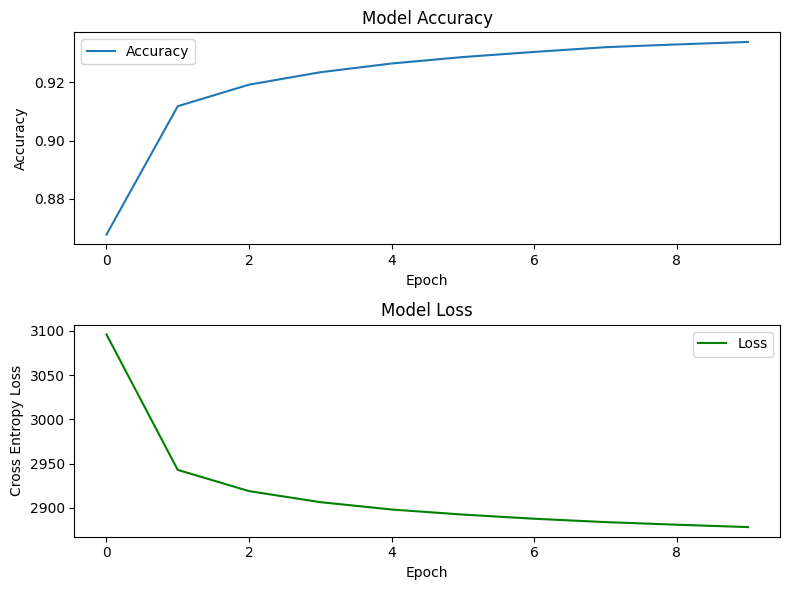

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(train_accuracies, label='Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(train_losses, 'g', label='Loss')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()

fig.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

## Evaluating Model

Finally, we check the metrics of our model on the test data by using the method `.evaluate()`:

In [ ]:
# Evaluation in PyTorch
model.eval()  # Set model to evaluation mode

correct = 0
total = 0
loss_total = 0.0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss_total += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

avg_loss = loss_total / len(test_loader)
accuracy = correct / total

print('Test loss:', avg_loss)
print('Test accuracy:', accuracy)


Test loss: 1.5353766763553072
Test accuracy: 0.9317


# Training a Simple Multi-layer Perceptron

Earlier, we showed how to create a simple network that maps directly from $784$ (input size) to $10$ (output size). In the following sections, we explain the basics of creating more complex models, models that combine different sequential layers to perform more accurate classifications.

Hence, we start by defining a network with an extra layer and study how that affects the final test accuracy.

In [ ]:
from torchsummary import summary  # You may need to install this via pip

In [ ]:
# Define the model
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1)  # Only needed for inference, not for training with CrossEntropyLoss
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
model2 = SimpleMLP()

# Print model summary (input size is (batch_size, 784))
summary(model2, input_size=(784,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 10]           1,010
           Softmax-4                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


We have increased the number of parameters from 7850 to 79510 by adding this layer. Remember that the number of units given to the last layer defines the dimensionality of the output space, thus, we need the last layer to have the same size that the total number of classes to classify.

Note that we use ReLU (Rectified Linear Unit) activation function after the first dense layer. ReLU is a common activation function, we will give more details about it in future tutorials. However, for now, you can learn more about ReLU [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

We train our new model and visualise the model curves:

Epoch 1: Loss=0.3065, Accuracy=0.9150
Epoch 2: Loss=0.1367, Accuracy=0.9600
Epoch 3: Loss=0.0958, Accuracy=0.9720
Epoch 4: Loss=0.0726, Accuracy=0.9779
Epoch 5: Loss=0.0573, Accuracy=0.9827
Epoch 6: Loss=0.0465, Accuracy=0.9854
Epoch 7: Loss=0.0390, Accuracy=0.9875
Epoch 8: Loss=0.0316, Accuracy=0.9904
Epoch 9: Loss=0.0272, Accuracy=0.9917
Epoch 10: Loss=0.0219, Accuracy=0.9934


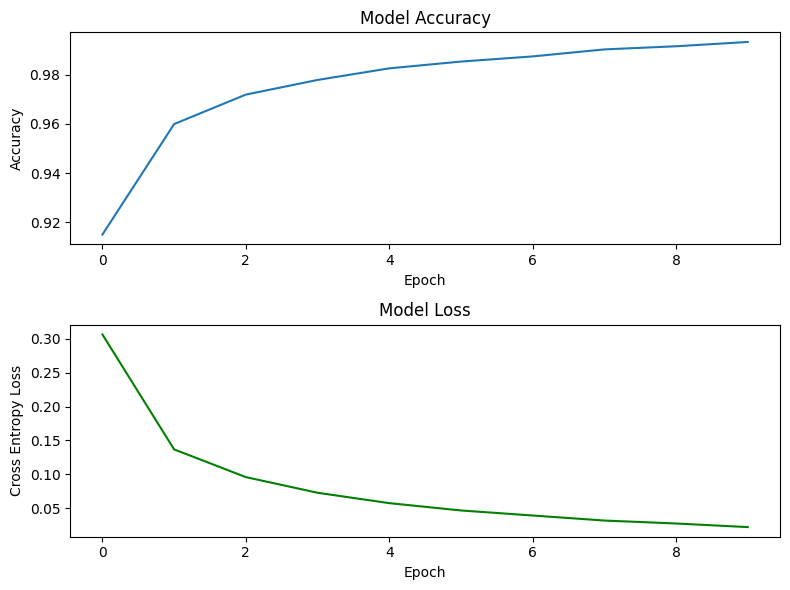

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model, loss, optimizer
model2 = SimpleMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Prepare DataLoader
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_flatten, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.long))  # use class labels directly
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train model and record history
epochs = 10
train_loss_history = []
train_acc_history = []

for epoch in range(epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model2(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total

    train_loss_history.append(avg_loss)
    train_acc_history.append(accuracy)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}")

# Plotting accuracy and loss
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(train_acc_history)
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

axes[1].plot(train_loss_history, 'g')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')

fig.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


We have now trained two different models. Let's plot their metrics to see how that extra layer affected the results in the network performance.

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        labels = torch.tensor(y_test, dtype=torch.long)
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).float().mean().item()
    return loss.item(), accuracy

# Evaluate both models
loss1, acc1 = evaluate_model(model, X_test_flatten, y_test)
loss2, acc2 = evaluate_model(model2, X_test_flatten, y_test)

# Print results
print("Old model:")
print(f"Test loss: {loss1:.4f}")
print(f"Test accuracy: {acc1:.4f}")

print("New model:")
print(f"Test loss: {loss2:.4f}")
print(f"Test accuracy: {acc2:.4f}")


Old model:
Test loss: 1.5354
Test accuracy: 0.9317
New model:
Test loss: 0.0834
Test accuracy: 0.9765


We have improved accuracy results on the test set. Even though there is still margin for parameter tuning, the reached accuracy is already pretty high. We could add more layers or change the number of neurons in each layer to see if we could boost even further the results.

Let's now explore some techniques that will prove useful in the following tutorials.

## Saving/Loading Model

Some networks require long training times (hours, days or even weeks), hence, it is essential to know how to save the models for using them in future times without the need of retraining them every time.

We can save and load the trained model in different ways.

The first way is to save everything into a single PTH file, which will contain:

*   the architecture of the model, allowing to re-create the model
*   the weights of the model
*   the training configuration (loss, optimiser)
*   the state of the optimiser, which permits us to resume training exactly where you left it off.


In [ ]:
# Save model (architecture + weights + optimizer state if needed)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional: only needed if resuming training
}, 'my_model.pth')


Once we have a model defined, we can load the weights with the method `load_state_dict(torch.load(file_path))`.:

In [ ]:
model.load_state_dict(torch.load('my_model_weights.pth'))
model.eval()

### Download Models / Save to Google Drive
One of the problems you may face is that the models, or any other file, saved in Colab will not be there permanently. In some cases, you will want to store your model weights in a more lasting way. There are two ways to save your model. First, you can download any file to your computer. To do so, you can use the left-side menu in Colab, and follow the instructions on the image below.

![Screenshot](https://i.ibb.co/yS5JgPd/Screenshot-2021-01-18-at-15-46-04.png)

If you want to use any file you previously downloaded, you will need to manually upload your file using the Colab interface.

Another way to save your weights is by using your Google Drive storage. This can be more convenient, as you can quickly load the models again from your Drive without having to upload manually the file. To do so, you can click on the folder with the Drive symbol highlighted in the following image.

![Screenshot](https://i.ibb.co/PFGw6QR/Screenshot-2021-01-18-at-16-16-44.png)

After clicking on the Drive folder, the code below will appear in your Colab notebook. You need to run it and follow the instructions to have access to your Google Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

After the `drive` folder is mounted, you will see a new folder on your files section in Colab as in the following image.

![Screenshot](https://i.ibb.co/NSM1RFK/Screenshot-2021-01-18-at-16-17-48.png)

Now, you can save the model to your personal Google Drive and also load any model from it.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/my_model_weights.pth')
model.load_state_dict(torch.load('/content/drive/MyDrive/my_model_weights.pth'))

Using your Google Drive storage is quite convenient. However, keep in mind that any file saved in your drive will also count towards your Google Drive storage limit.

## Obtaining an Output of an Intermediate Layer

Sometimes we need to check how features of intermediate layers look like. This can be used for extracting features, but also for debugging purposes. That is why we need to see how we can obtain information about any layer within the architecture.

The easiest way is to design a new model that will have as final output our desired layer. We first define the model:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_dense = nn.Linear(784, 64)
        self.second_dense = nn.Linear(64, 128)
        self.final_dense = nn.Linear(128, 10)

    def forward(self, x):
        x1 = F.relu(self.first_dense(x))   # "first_dense" output
        x2 = F.relu(self.second_dense(x1)) # "second_dense" output
        x3 = F.softmax(self.final_dense(x2), dim=1)  # "final_dense" output
        return x1, x2, x3  # return all intermediate activations


In [ ]:
model = CustomMLP()
model.eval()

# Example input
sample_input = torch.randn(1, 784)  # single flattened image
first_out, second_out, final_out = model(sample_input)

print("First Dense Output Shape:", first_out.shape)
print("Second Dense Output Shape:", second_out.shape)
print("Final Output (Softmax):", final_out)


First Dense Output Shape: torch.Size([1, 64])
Second Dense Output Shape: torch.Size([1, 128])
Final Output (Softmax): tensor([[0.1011, 0.0855, 0.1042, 0.1059, 0.0950, 0.1068, 0.0891, 0.1059, 0.1060,
         0.1006]], grad_fn=<SoftmaxBackward0>)


Now, we specify the name of the layer in which we are interested in obtaining the output. In our example, it is the second dense layer ("second_dense"), for which we extract the output from the reconstruction of the network.

In [ ]:
def get_intermediate_output(model, x, layer_name="second_dense"):
    x1 = F.relu(model.first_dense(x))
    if layer_name == "first_dense":
        return x1
    x2 = F.relu(model.second_dense(x1))
    if layer_name == "second_dense":
        return x2
    x3 = F.softmax(model.final_dense(x2), dim=1)
    return x3

## Freezing Layers

Pytorch also allows us to freeze some of the weights of specific layers. Freezing layers means that we can exclude them from training. A typical example where this proved useful is when fine-tuning a model. Remember that when fine-tuning a model, some layers are fixed, and normally only the last ones are trained to finetune the task-specific layers (e.g. classifiers) to the new task.

To freeze layers we can set the requires grad argument (Boolean) of the layer to be non-trainable or trainable:

In [ ]:
# Define a frozen dense layer (Linear layer in PyTorch)
frozen_layer = nn.Linear(in_features=64, out_features=32)

# Freeze it: disable gradient computation
for param in frozen_layer.parameters():
    param.requires_grad = False

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import copy

# Instantiate model
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)

print("Summary before freezing:")
summary(model, input_size=(784,))

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

print("\nSummary after freezing:")
summary(model, input_size=(784,))

# Additionally print trainable parameters count and flag for each param
def print_trainable_params(model):
    print("\nParameter trainability:")
    for name, param in model.named_parameters():
        print(f"{name:30} | trainable: {param.requires_grad}")

print_trainable_params(model)


Summary before freezing:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
           Softmax-2                   [-1, 10]               0
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------

Summary after freezing:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
           Softmax-2                   [-1, 10]               0
Total params: 7,850
Trainable params: 0
Non-trainable params: 7,850
-------------------------------------------------------

We see in the model description that the frozen model has 0 trainable parameters, while it has 7,850 non-trainable parameters. This fact indicates that we successfully froze that model and the training does not affect it. We can verify this using the results after training both networks, where the trainable model improves accuracy while the frozen one does not change at all.